## **Import Libraries**

In [24]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import graphviz
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix

## **Load dataset**

In [2]:
data = load_breast_cancer()
features = pd.DataFrame(data.data, columns=data.feature_names)
labels = pd.Series(data.target, name="target")

## **Split dataset into training and testing set**

### **Save data**

In [3]:
def split_and_save_data(features, labels, ratio_test=0.4, root_folder='data'):
    """
    Splits the dataset into training and testing sets based on the specified ratio, 
    then saves the split data into CSV files within a structured folder hierarchy.

    Args:
        features (pd.DataFrame): Input dataset containing the features to be split.
        labels (pd.Series): Corresponding labels for the input dataset.
        ratio_test (float, optional): Proportion of the data to be used for testing. 
            Defaults to 0.4 (60% train, 40% test).
        root_folder (str, optional): Root directory where the split data will be saved. 
            Defaults to 'data.
    """
    
    train_percent = int((1 - ratio_test) * 100)
    test_percent = int(ratio_test * 100)
    
    os.makedirs(root_folder, exist_ok=True)
    
    base_folder_name = f"train_{train_percent}_test_{test_percent}"
    base_folder = os.path.join(root_folder, base_folder_name)
    os.makedirs(base_folder, exist_ok=True)
    
    train_folder = os.path.join(base_folder, "train")
    test_folder = os.path.join(base_folder, "test")
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=ratio_test, random_state=42)
    for train_index, test_index in sss.split(features, labels):
        train_features, test_features = features.iloc[train_index], features.iloc[test_index]
        train_labels, test_labels = labels.iloc[train_index], labels.iloc[test_index]
        
        train_features.to_csv(os.path.join(train_folder, "feature_train.csv"), index=False)
        train_labels.to_csv(os.path.join(train_folder, "label_train.csv"), index=False, header=False)
        
        test_features.to_csv(os.path.join(test_folder, "feature_test.csv"), index=False)
        test_labels.to_csv(os.path.join(test_folder, "label_test.csv"), index=False, header=False)
    
    

In [38]:
split_and_save_data(features, labels, ratio_test=0.6)
split_and_save_data(features, labels, ratio_test=0.4)
split_and_save_data(features, labels, ratio_test=0.2)
split_and_save_data(features, labels, ratio_test=0.1)

### **Training and testing data**

In [4]:
def load_split_data(ratio_test=0.4, root_data='data'):
    """
    Loads the train and test datasets from CSV files saved previously, 
    based on the specified ratio for the test dataset.

    Args:
        ratio_test (float, optional): Proportion of the data to be used for testing. 
            Defaults to 0.4 (40% test, 60% train).
        root_folder (str, optional): Root directory where the split data is saved. 
            Defaults to "data".

    Returns:
        X_train (pd.DataFrame): The features of the training set.
        y_train (pd.Series): The labels of the training set.
        X_test (pd.DataFrame): The features of the testing set.
        y_test (pd.Series): The labels of the testing set.
    """
    
    train_percent = int((1 - ratio_test) * 100)
    test_percent = int(ratio_test * 100)
    
    base_folder_name = f"train_{train_percent}_test_{test_percent}"
    base_folder = os.path.join(root_data, base_folder_name)
    
    train_folder = os.path.join(base_folder, "train")
    test_folder = os.path.join(base_folder, "test")
    
    X_train = pd.read_csv(os.path.join(train_folder, "feature_train.csv"))
    y_train = pd.read_csv(os.path.join(train_folder, "label_train.csv"), header=None).squeeze()
    
    X_test = pd.read_csv(os.path.join(test_folder, "feature_test.csv"))
    y_test = pd.read_csv(os.path.join(test_folder, "label_test.csv"), header=None).squeeze()
    
    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = load_split_data(ratio_test=0.4)

### **Visualize the data**

In [6]:
def visualize_class_distribution(original_labels, train_labels, test_labels):
    original_counts = original_labels.value_counts()
    train_counts = train_labels.value_counts()
    test_counts = test_labels.value_counts()
    
    classes = sorted(original_counts.index)
    original_counts = original_counts.reindex(classes)
    train_counts = train_counts.reindex(classes)
    test_counts = test_counts.reindex(classes)
    
    plt.figure(figsize=(12, 6))
    
    x = range(len(classes))
    width = 0.2
    
    plt.bar([i - width for i in x], original_counts, width=width, label='Original', color='blue')
    plt.bar(x, train_counts, width=width, label='Train', color='green')
    plt.bar([i + width for i in x], test_counts, width=width, label='Test', color='red')
    
    plt.xticks(x, [f'Class {cls}' for cls in classes])
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Class Distribution in the Original, Train, and Test Datasets')
    plt.legend()
    plt.tight_layout()
    
    plt.show()

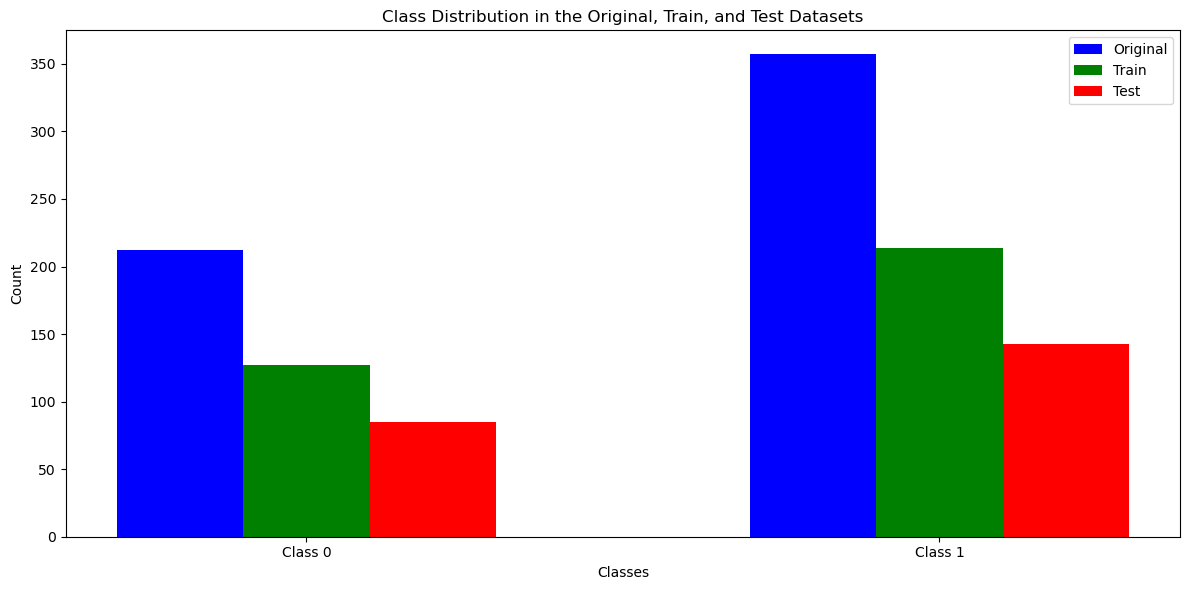

In [7]:
visualize_class_distribution(
    original_labels=labels,
    train_labels=y_train,
    test_labels=y_test
)

## **Training**

In [10]:
def train_decision_tree(X_train, y_train, criterion='entropy', max_depth=None, feature_names=None):
    """
    Trains a decision tree classifier on the input features and labels.

    Args:
        X_train (pd.DataFrame): The input features of the training set.
        y_train (pd.Series): The labels of the training set.
        max_depth (int, optional): The maximum depth of the decision tree. 
            Defaults to None.

    Returns:
        model (DecisionTreeClassifier): The trained decision tree classifier.
    """
    
    # Train decision tree classifier
    model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    
    # Visualize the decision tree  
    if feature_names is not None:
        dot_data = export_graphviz(
            model, out_file=None,
            feature_names=feature_names,
            class_names=np.unique(y_train).astype(str),
            filled=True, rounded=True,
            special_characters=True
        )
        
        graph = graphviz.Source(dot_data)
        graph.render("decision_tree")
        graph.view()
    
    return model

In [12]:
model = train_decision_tree(X_train, y_train, max_depth=2, feature_names=X_train.columns)

## **Evaluation**

In [25]:
def evaluate_decision_tree(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), annot_kws={'size': 16})
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.90        85
           1       0.97      0.90      0.93       143

    accuracy                           0.92       228
   macro avg       0.91      0.92      0.91       228
weighted avg       0.92      0.92      0.92       228

Confusion Matrix:
[[ 81   4]
 [ 15 128]]


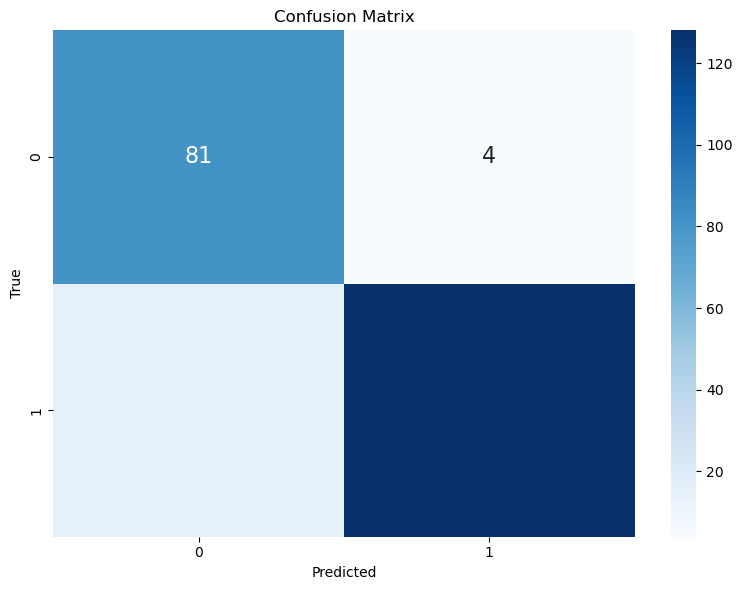

In [26]:
evaluate_decision_tree(model, X_test, y_test)